# Link: https://patches12306.github.io/patches12306/


### Garrett Van Beek
### Ben Nguyen
### Intro to Data Science
### Professor Nick Mattei

# Final Tutorial Milestone 1: “Can you Google the stock market?"

For our project we plan to collect data on search traffic from Google and Twitter and see how that data correlates with the performances of certain publicly traded stocks. For example, one question we would like to ask is “how does the search traffic about clean energy sources correlate with the performance of clean energy stocks?”. We would also like to see how the sentiment about certain topics correlates to their stock. For this, we plan to use a python library Twitter Sentiment Analysis or Tweepy. This tool gives us a sentiment rating that we can compare to our stock’s performance. We will most likely analyze our data as line graphs. This way we can see how stock performance, search traffic, and sentiment change over time. Consequently, we hope to find correlations and gain insight on the data.

We hope to tackle topics that are a bit more controversial or nuanced than clean energy. Some of the questions that we have thought of asking are: “How does search traffic on sex scandals within companies correlate to the stocks of the companies?” We can also observe the effects of influencers like Donald Trump or Kanye West have on the stock market. We can observe their twitter comments about certain topics and then observe how stocks relating to these topic’s perform. Another angle we can observe is how the general sentiment on topics will correlate to related stocks. For example, we can ask “How does the sentiment about Elon Musk correlate to the stock performance of TESLA?”

For our information on stock performance we plan on scraping or downloading data from Yahoo Finance, which contains a barrage of data on publicly traded stocks. Links to the datasets, tools, and websites we plan to use are provided below.

https://trends.google.com/trends/?geo=US https://www.tweepy.org/ https://github.com/shaypal5/awesome-twitter-data https://finance.yahoo.com/

tutorial project for datascience

# Final Tutorial Milestone 2

## Questions
Our overall goal is to determine "Can we google the stock market?" By this we mean "can we find correlations between google search trends/twitter activity on certain topics and the performance of stocks related to those topics?"

This is a very general questions so we will answer two specific questions based on our search history. 

### 1. How does Elon Musk's Twitter activity correlate to the stock performance of Tesla. How do search trends on Elon Musk correlate to the performance of Tesla Stock?
Note: we are currently waiting for authorization to use Twitter's Tweepy API. Until then, we will be using google trend data from Google Trends.

#### Step One: Wrangle the Data
We downloaded google search, and yahoo finance data as CSVs. Our goal is to create a DataFrame where every day is a row, and the columns are:

1. Search trends of Elon Musk (Google)
2. Performance of TESLA Stock (Yahoo)
3. Performance of PAYPAL Stock (Yahoo)

Our timeframe for these questions will be 2016-2018

In [19]:
#Import Statements
import pandas as pd
import re
import datetime
import statsmodels.api as sm
import seaborn as sns

### Code Description:
First we created 3 dataframes from Tesla and Paypal stock data and Elon Musk Google Search trend data.

We then converted the converted the dates in the Google Trends dataframe to datetime objects. Since all our data was collected on Sundays, we rolled every data entry one day forward. This way we could match trend data rows to rows in our stock price tables. (The stock market does not open on Sundays)

Next we created a new column where we turned the datetimes back into strings.  We then inner left merged the dataframes on this datetime string column.

In [20]:
#Read csv into dataframe
tesla_df = pd.read_csv('./data/tesla2016-2018.csv')
paypal_df = pd.read_csv('./data/paypal2016-2018.csv')
elon_df = pd.read_csv('./data/elon2016-2018.csv')


#Turn date strings into datetime objects.
dateTimeList = []
for d in elon_df['Week']:
    date = re.split('/', d)
    dateObject = datetime.datetime(
        int(date[2]),
        int(date[0]),
        int(date[1]))
    # Increase the day by one so that it lines up with the date in the other data frames.
    dateTimeList.append(dateObject + datetime.timedelta(days=1))
elon_df['Date_time'] = dateTimeList

# Make a column of date strings to use as a key to merge on.
stringArray = []
for d in elon_df['Date_time']:
    date_as_string = d.isoformat()
    stringArray.append(date_as_string[0:10])
elon_df['Date'] = stringArray

# Merge the three data frames
joined_df = pd.merge(tesla_df, paypal_df, on="Date", how="inner", suffixes=('_t','_p'))
complete_df = pd.merge(joined_df, elon_df, on="Date", how="left")

drop_df = complete_df.drop(columns=['Open_t', 'High_t','Low_t','Adj Close_t','Open_p','High_p','Low_p','Adj Close_p'])

# TODO: Rename the columns
drop_df = drop_df.rename(columns={"Close_t": "Tesla_price", "Volume_t": "Tesla_volume", "Close_p":"Paypal_price", 
                        "Volume_p":"Paypal_volume", "elon musk: (United States)": "Elon_Musk_Search_Rate"})

#drops unecessary columns to show correlatotio between elon musk, tesla price, and paypal price
final_df = drop_df.drop(columns =['Tesla_volume','Paypal_volume','Week','Date_time'])

# Display the dataframe
final_df.head()



,Date,Tesla_price,Paypal_price,Elon_Musk_Search_Rate
0,2016-01-04,223.410004,34.750000,4.0
1,2016-01-05,223.429993,34.310001,NaN
2,2016-01-06,219.039993,33.980000,NaN
3,2016-01-07,215.649994,33.130001,NaN
4,2016-01-08,211.000000,32.689999,NaN


#### Step Two: Standardize the data.
Google's trend data was normalized. In order to compare our stock data to google's trend data we must normalize it.

$ standardized value = ((individual value) - (mean value)) / standard deviation $

In order to easily standardize our data, I first computed the mean of each column. Then, I computed the standard deviation of each column. Finally, I used .apply to apply to standardization formula to our data.


In [21]:
# Get the mean Paypal_price and mean Tesla price
tsla_mean = final_df["Tesla_price"].mean()
pypl_mean = final_df["Paypal_price"].mean()
google_mean = final_df["Elon_Musk_Search_Rate"].mean()

# Compute the standard deviation for Paypal and Tesla prices.
tsla_std = final_df["Tesla_price"].std()
pypl_std = final_df["Paypal_price"].std()
google_std = final_df["Elon_Musk_Search_Rate"].std()

# Define a functions to standardize Paypal Price and Tesla Price
def normalize_tesla(tsla_value):
    return ((tsla_value - tsla_mean) / (tsla_std))

def normalize_pypl(pypl_value):
    return ((pypl_value - pypl_mean) / (pypl_std))

def normalize_google(google_value):
    return ((google_value - google_mean) / (google_std))

# Add columns with standardized price
final_df["stand_Tesla_Price"] = final_df["Tesla_price"].apply(normalize_tesla)
final_df["stand_Paypal_Price"] = final_df["Paypal_price"].apply(normalize_pypl)
final_df["stand_Elon_Search_Rate"] = final_df["Elon_Musk_Search_Rate"].apply(normalize_google)

final_df

,Date,Tesla_price,Paypal_price,Elon_Musk_Search_Rate,stand_Tesla_Price,stand_Paypal_Price,stand_Elon_Search_Rate
0,2016-01-04,223.410004,34.750000,4.0,-0.964026,-1.222538,-0.826748
1,2016-01-05,223.429993,34.310001,NaN,-0.963687,-1.244830,NaN
2,2016-01-06,219.039993,33.980000,NaN,-1.037986,-1.261549,NaN
3,2016-01-07,215.649994,33.130001,NaN,-1.095359,-1.304613,NaN
4,2016-01-08,211.000000,32.689999,NaN,-1.174058,-1.326905,NaN
...,...,...,...,...,...,...,...
749,2018-12-24,295.390015,77.059998,15.0,0.254192,0.921027,0.076866
750,2018-12-26,326.089996,82.800003,NaN,0.773771,1.211835,NaN
751,2018-12-27,316.130005,84.309998,NaN,0.605204,1.288336,NaN
752,2018-12-28,333.869995,83.260002,NaN,0.905443,1.235140,NaN


#### Step Three: Visualize the Data
Now that we have the data normalized, we will visualize scatter plots with linear regression lines between search trends and stock prices.

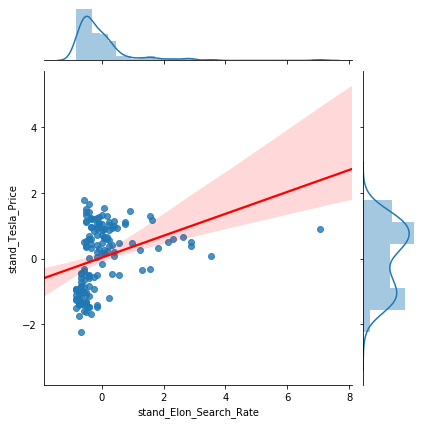

In [22]:
# Display 'Elon Musk' search frequency vs. Tesla Stock Price
sns.jointplot(y='stand_Tesla_Price', x='stand_Elon_Search_Rate', data=final_df, kind='reg', joint_kws={'line_kws':{'color':'red'}})

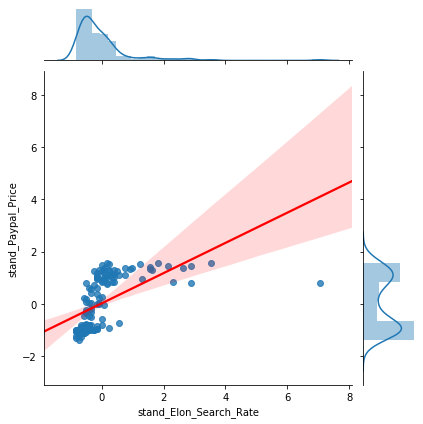

In [23]:
# Display 'Elon Musk' search frequency vs. Paypal Stock Price
sns.jointplot(y='stand_Paypal_Price', x='stand_Elon_Search_Rate', data=final_df, kind='reg', joint_kws={'line_kws':{'color':'red'}})

#### Step Four: Compute correlations between the data
Let's get the Pearson Correlation Coefficient to see how closely the data is correlated.

From here we can see there is a very high correlation between Paypal Price and the search frequency of Elon Musk. Also, there is a positive correlation between Elon Musk search frequency and Tesla price, although, it is not as strong as that of Paypal.

In [24]:
#Compute correlations within the data.
final_df[["Tesla_price", "Paypal_price", "Elon_Musk_Search_Rate"]].corr()

,Tesla_price,Paypal_price,Elon_Musk_Search_Rate
Tesla_price,1.000000,0.730257,0.336975
Paypal_price,0.730257,1.000000,0.582043
Elon_Musk_Search_Rate,0.336975,0.582043,1.000000


### TODO: organize our project in a way that reads cleanly:
#### Research question:
What is a better indicator of stock price Google Trends, Twitter Sentiment/"viralness", or Reddit posts?
#### Hypothesis:
Twitter Sentiment will be the strongest indicator of stock price, because it not only records how strong a public sentiment but it reaches a large demographic. Reddit will be the least strong indicator, because it has a younger demographic and young people invest at lower rates.

### Setup Tweepy

In [3]:
# install tweepy using conda
# conda install -c conda-forge tweepy

import tweepy

my_consumer_key = "vH6sNgPSLKMnLOLhlefyL4n2o"
my_consumer_secret = "QbZOYfEBOHFi6LiX6BJKsAUa96NRsE4xkM0KdCJ06oDHXrosad"

tweepy_auth = tweepy.OAuthHandler(my_consumer_key, my_consumer_secret)

#NOTE: I am not sure if we need to do an access token dance, so far I haven't run into any trouble.
#tweepy_auth.set_access_token(access_token, access_token_secret)


my_api = tweepy.API(tweepy_auth)

In [14]:
# get an elon musk user object.
tw_elon = my_api.get_user('elonmusk')
tw_elon

User(_api=<tweepy.api.API object at 0x00000218F994BCC0>, _json={'id': 44196397, 'id_str': '44196397', 'name': 'Elon Musk', 'screen_name': 'elonmusk', 'location': '', 'profile_location': None, 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 29335275, 'friends_count': 80, 'listed_count': 52014, 'created_at': 'Tue Jun 02 20:12:29 +0000 2009', 'favourites_count': 4232, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': True, 'statuses_count': 9264, 'lang': None, 'status': {'created_at': 'Fri Nov 15 19:02:17 +0000 2019', 'id': 1195416750961106944, 'id_str': '1195416750961106944', 'text': 'Innovation comes in many ways https://t.co/3plylbd1eZ', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/3plylbd1eZ', 'expanded_url': 'https://twitter.com/casey/status/1195397575089647616', 'display_url': 'twitter.com/casey/status/1…', 'indices': [30, 53